# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [17]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.2.0


# Preparing Training and Test Sets

In [8]:
# class_names = ['normal', 'viral', 'covid']
# root_dir = 'COVID-19 Radiography Database'
# train_dir = os.path.join('COVID-19 Radiography Database', 'train')
# source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

# if os.path.isdir(os.path.join(train_dir, source_dirs[1])):
#     os.mkdir(os.path.join(train_dir, 'test'))
#     for i, d in enumerate(source_dirs):
#         os.rename(os.path.join(train_dir, d), os.path.join(train_dir, class_names[i]))
#     for c in class_names:
#         os.mkdir(os.path.join(train_dir, 'test', c))

# for c in class_names:
#     images = [x for x in os.listdir(os.path.join(train_dir, c)) if x.lower().endswith('png')]
#     selected_images = random.sample(images, 200)
#     for image in selected_images:
#         source_path = os.path.join(train_dir, c, image)
#         target_path = os.path.join(train_dir, 'test', c, image)
#         shutil.move(source_path, target_path)

# Creating Custom Dataset

In [186]:
import torch.utils
import torch.utils.data


class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [os.path.join(image_dirs[class_name], x) for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = []
        self.labels = []

        self.class_names = ['normal', 'viral', 'covid']
        
        for i, class_name in enumerate(self.class_names):
            class_images = get_images(class_name)
            self.images.extend(class_images)
            self.labels.extend([i] * len(class_images))

        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), label


# Image Transformations

In [187]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [188]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [189]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/train/normal',
    'viral': 'COVID-19 Radiography Database/train/viral',
    'covid': 'COVID-19 Radiography Database/train/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9962 normal examples
Found 1115 viral examples
Found 3386 covid examples


In [190]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 230 normal examples
Found 230 viral examples
Found 230 covid examples


In [191]:
import torch.utils.data.dataloader


batch_size = 128

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size,
                                       shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size,
                                      shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))


Num of training batches 113
Num of test batches 6


# Data Visualization

In [202]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images[:6]):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

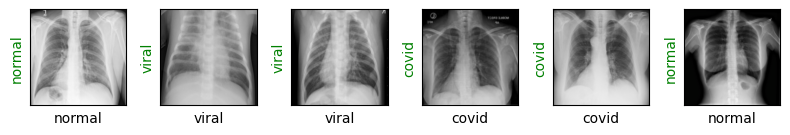

In [203]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

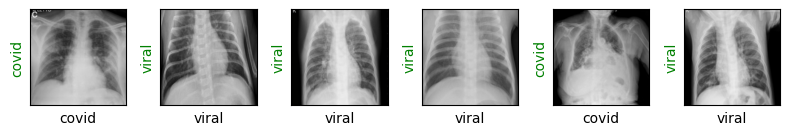

In [204]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [205]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

c:\Users\57646\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\57646\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\57646/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [206]:
resnet18.fc = torch.nn.Linear(512, 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [207]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images, labels, preds)

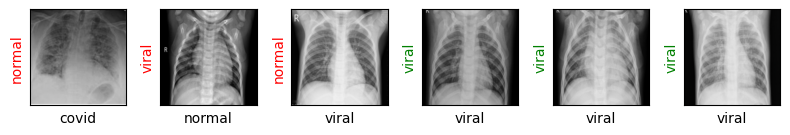

In [208]:
show_preds()

# Training the Model

In [211]:
def train(epochs):
    print('Starting training...')
    for e in range(epochs):
        print('=' * 20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('=' * 20)

        train_loss = 0

        resnet18.train()

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0.
                resnet18.eval()

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()

                resnet18.train()

                if acc > 0.95:
                    print('Performance condition satisfied...')
                    return
                
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
        

Starting training...
Starting epoch 1/5
Evaluating at step 0
Val loss: 1.0786, Acc: 0.4913


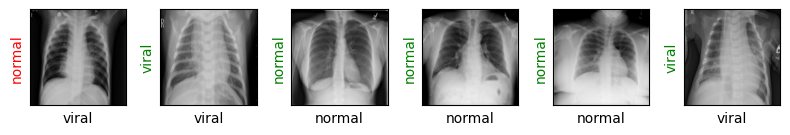

Evaluating at step 20
Val loss: 0.5892, Acc: 0.8696


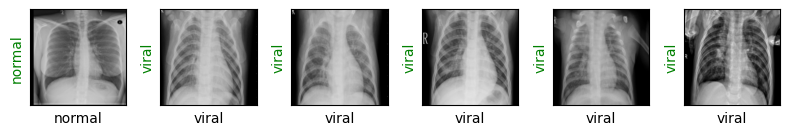

Evaluating at step 40
Val loss: 0.3165, Acc: 0.9217


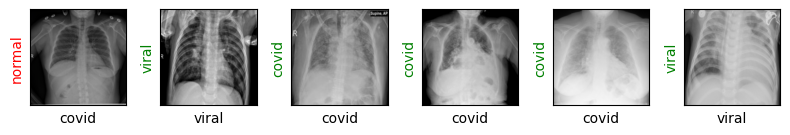

Evaluating at step 60
Val loss: 0.1877, Acc: 0.9449


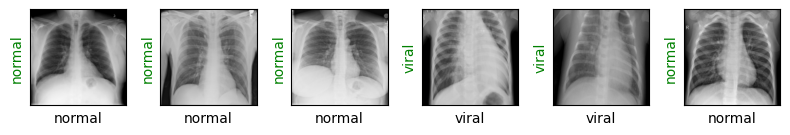

Evaluating at step 80
Val loss: 0.1320, Acc: 0.9652


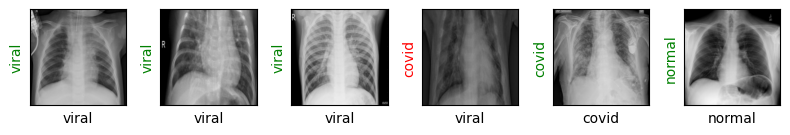

Performance condition satisfied...


In [212]:
train(epochs=5)

# Final Results

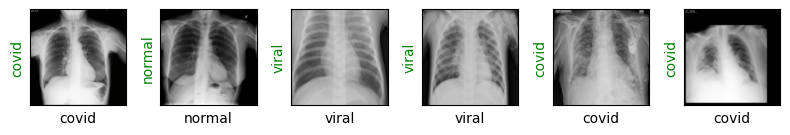

In [213]:
show_preds()